* This notebook was made to evaluate mean current (only forced by river flow) during low river flow period by comparing with codar data.

In [1]:
%matplotlib inline
from IPython.core.display import Image
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io as sio
import datetime
from salishsea_tools import (viz_tools,tidetools,nc_tools)
import matplotlib.gridspec as gridspec
import numpy.ma as ma
import os
import codar

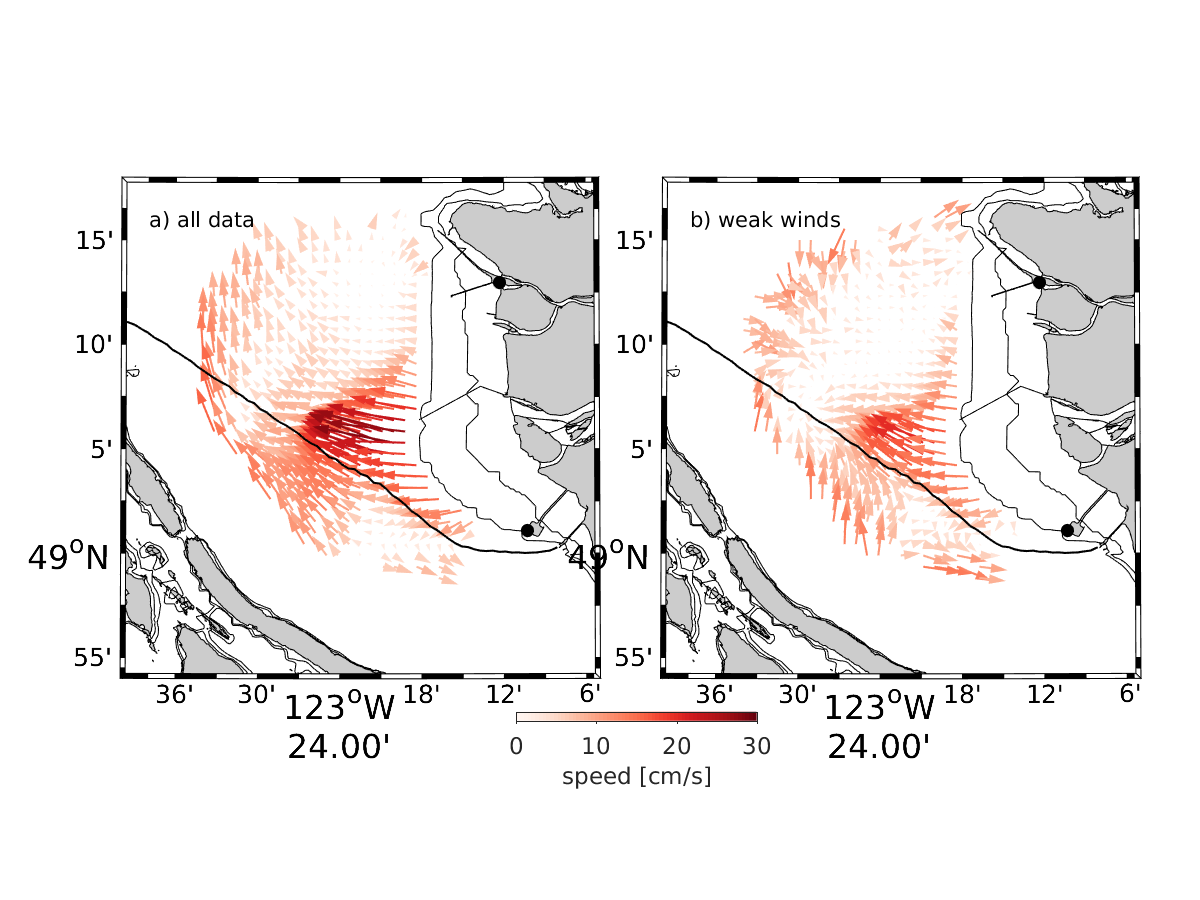

In [2]:
Image(filename='/ocean/jieliu/research/meopar/surface current/average_CODAR_Sep_Oct_2014.png')

In [3]:
## load data
codar_data = sio.loadmat('/ocean/jieliu/research/meopar/surface current/SoG_radar_totals.mat')
t = codar_data['mtime']
lat_codar = codar_data['glat']
lon_codar = codar_data['glon']
u = codar_data['u']
v = codar_data['v']

In [4]:
## load different bathys
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X={};Y={};bathy={};grids = [grid2,grid6]
for grid in grids:
    X[grid] = grid.variables['nav_lon'][:, :]
    Y[grid] = grid.variables['nav_lat'][:, :]
    bathy[grid] = grid.variables['Bathymetry'][:, :]

# Research Questions:

* 1) During which time period would i like to take a look at the mean river flow of model results? For a month, a week??
* 2) Based on the all data and weak wind case, should I also average over the same period as what I did for the codar data? Or use the same mean current of the codar data? The essence is that what does "mean current" mean in my case? Should I make them in the same period?
* 3) By evaluating the mean current field of model result, I hope to get some insights about explaining the mouth region is saltier in the long river simulation. I don't know if this might help or not...

In [5]:
run_low = datetime.datetime(2015,10,1,0);
run_up = datetime.datetime(2015,11,1,0);

In [6]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)
st=3

In [7]:
def setmask_region(lon,lat,lon_min, lon_max, lat_min, lat_max):
    """Besides rectangular region defined
    by lon_min, lon_max, lat_min, lat_max, other regions in the model domain
    are set to be masked, with the purpose of plotting without showing other regions """
    
    x_ind, y_ind = np.where((lon< lon_min) | (lon > lon_max) 
                           | (lat < lat_min) | (lat > lat_max))
    
    return x_ind, y_ind

In [9]:
def plot_both(run_low,run_up, cmin=0,cmax = 0.3 ):
    fig = plt.figure(figsize=(42,12))
    gs = gridspec.GridSpec(1, 3,width_ratios=[1, 1,1])  
    gs.update(hspace=0.15, wspace=0.1)
    ##plot codar quiver
    ax0 = fig.add_subplot(gs[0,0])
    viz_tools.plot_coastline(ax0, grid6, coords = 'map')
    viz_tools.plot_coastline(ax0, grid6, coords = 'map', isobath = 5,color = 'OrangeRed')
    viz_tools.plot_land_mask(ax0,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    ax0.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    ave_u, ave_v = codar.average_codar(run_low,run_up,t,u,v) ## get average codar data
    ## plot codar
    mesh=ax0.pcolormesh(lon_codar,lat_codar, ma.masked_invalid(np.sqrt(ave_u**2+ave_v**2)), cmap='bwr', \
                        vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(mesh, ax=ax0)
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = ax0.quiver(lon_codar, lat_codar,ave_u,ave_v, pivot='mid', scale = 5,width=0.005, color='black')
    ax0.quiverkey(quiver,-123.1,49.25, 0.3, '0.3 m/s',coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '15'})
    print ('mean flow of codar is '+str(np.nanmean(np.sqrt(ave_u**2+ave_v**2)))+' m/s')
    ## plot modelled surface currents
    ax1 = fig.add_subplot(gs[0,1]); ax2 = fig.add_subplot(gs[0,2])
    u_grid = nc.Dataset('mean_U.nc','r'); v_grid = nc.Dataset('mean_V.nc','r'); 
    u_m = {};v_m = {};U_m ={};V_m={};
    #for ax,grid in zip([ax1,ax2],grids):
    u_m[grid2] =u_grid.variables['vozocrtx'][0, 0,jst-1:jen,ist-1:ien]
    v_m[grid2] =v_grid.variables['vomecrty'][0, 0,jst-1:jen,ist-1:ien]
    ##unstagger u v
    U_m[grid2],V_m[grid2] = viz_tools.unstagger(u_m[grid2],v_m[grid2])
    #rotate
    theta = np.pi*29/180
    U_m[grid2] = U_m[grid2]*np.cos(theta) - V_m[grid2]*np.sin(theta)
    V_m[grid2] = U_m[grid2]*np.sin(theta) +V_m[grid2]*np.cos(theta)
    ##mask
    U_m[grid2]=np.ma.masked_values(U_m[grid2],0)
    V_m[grid2]=np.ma.masked_values(V_m[grid2],0)

    lon = X[grid2][jst:jen,ist:ien]
    lat = Y[grid2][jst:jen,ist:ien]
    mesh=ax1.pcolormesh(lon[380:460,240:320], lat[380:460,240:320], \
                        np.sqrt(U_m[grid2][380:460,240:320]**2+V_m[grid2][380:460,240:320]**2), cmap='bwr', vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(mesh, ax=ax1)
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = ax1.quiver(lon[380:460,240:320][::st,::st], lat[380:460,240:320][::st,::st],\
                        U_m[grid2][380:460,240:320][ ::st, ::st], V_m[grid2][380:460,240:320][::st,::st],\
                        pivot='mid',scale=5,width=0.005, color='black' )
    ax1.quiverkey(quiver,-123.1,49.25, 0.3, '0.3 m/s', coordinates='data', color='black', labelcolor='black',\
                fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax1,grid2,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(ax1, grid2, coords = 'map', isobath = 5,color = 'OrangeRed')
    codar.statistics_currents_mod(lon,lat,np.nanmin(lon_codar),np.nanmax(lon_codar),\
                                np.nanmin(lat_codar),np.nanmax(lat_codar), U_m[grid2], V_m[grid2])## mean modelled flow
  
    xind,yind = setmask_region(lon,lat,np.nanmin(lon_codar),\
                               np.nanmax(lon_codar),np.nanmin(lat_codar),np.nanmax(lat_codar))
    #mesh=ax2.pcolormesh(lon[xind,yind], lat[xind,yind], \
                        #np.sqrt(U_m[grid2][xind,yind]**2+V_m[grid2][xind,yind]**2), cmap='bwr', vmin=cmin, vmax=cmax)
    #cbar = plt.colorbar(mesh, ax=ax1)
    #cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    #plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    #quiver = ax2.quiver(lon[xind,yind][::st,::st], lat[xind,yind][::st,::st],\
                        #U_m[grid2][xind,yind][ ::st, ::st], V_m[grid2][xind,yind][::st,::st],\
                        #pivot='mid',scale=5,width=0.005, color='black' )
    #ax2.quiverkey(quiver,-123.1,49.25, 0.3, '0.3 m/s', coordinates='data', color='black', labelcolor='black',\
                #fontproperties = {'size': '15'})
    #viz_tools.plot_land_mask(ax2,grid2,coords='map',xslice=x,yslice=y,color='burlywood')
    #viz_tools.plot_coastline(ax2, grid2, coords = 'map', isobath = 5,color = 'OrangeRed')
    #codar.statistics_currents_mod(lon,lat,np.nanmin(lon_codar),np.nanmax(lon_codar),\
                                #np.nanmin(lat_codar),np.nanmax(lat_codar),U_m[grid2], V_m[grid2])## mean modelled flow
    for ax in [ax0,ax1,ax2]:
        ax.set_xlim([-123.7,-123])
        ax.set_ylim([48.8,49.3])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])

    return fig

In [9]:
model_codar = nc.Dataset('/ocean/jieliu/research/meopar/surface current/CODAR.nc')
alon = model_codar.variables['nav_lon'] ## if select the codar_model domain as its min lon and lat
alat = model_codar.variables['nav_lat']
lon = X[grid2][jst:jen,ist:ien]
lat = Y[grid2][jst:jen,ist:ien]
xind,yind = setmask_region(lon,lat,np.nanmin(alon),np.nanmax(alon),\
                    np.nanmin(alat),np.nanmax(alat))

In [10]:
xind,yind = setmask_region(lon,lat,np.nanmin(lon_codar),\
                               np.nanmax(lon_codar),np.nanmin(lat_codar),np.nanmax(lat_codar))

In [11]:
    u_grid = nc.Dataset('mean_U.nc','r'); v_grid = nc.Dataset('mean_V.nc','r'); 
    u_m = {};v_m = {};U_m ={};V_m={};
    #for ax,grid in zip([ax1,ax2],grids):
    u_m[grid2] =u_grid.variables['vozocrtx'][0, 0,jst-1:jen,ist-1:ien]
    v_m[grid2] =v_grid.variables['vomecrty'][0, 0,jst-1:jen,ist-1:ien]
    ##unstagger u v
    U_m[grid2],V_m[grid2] = viz_tools.unstagger(u_m[grid2],v_m[grid2])
    #rotate
    theta = np.pi*29/180
    U_m[grid2] = U_m[grid2]*np.cos(theta) - V_m[grid2]*np.sin(theta)
    V_m[grid2] = U_m[grid2]*np.sin(theta) +V_m[grid2]*np.cos(theta)
    ##mask
    U_m[grid2]=np.ma.masked_values(U_m[grid2],0)
    V_m[grid2]=np.ma.masked_values(V_m[grid2],0)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


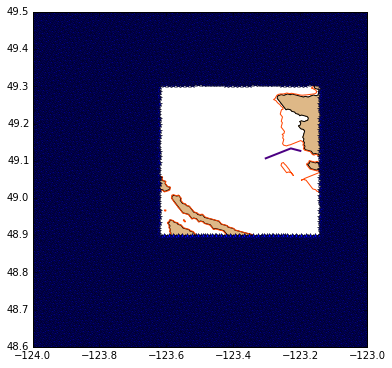

In [13]:
xind, yind= setmask_region(lon,lat,np.nanmin(lon_codar),np.nanmax(lon_codar),\
                                np.nanmin(lat_codar),np.nanmax(lat_codar))
fig,ax = plt.subplots(1,1,figsize = (6,6))
##plot codar quiver
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'OrangeRed')
viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
ax.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
ax.set_xlim([-124,-123])
ax.set_ylim([48.6,49.5])
#ax.plot(lon[380:460,240:320],lat[380:460,240:320],'*b')
ax.plot(lon[xind,yind],lat[xind,yind],'*b')

In [ ]:
for x, y in zip(xind,yind):
    lon = ma.masked_where(lon ==lon[x,y],lon)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


mean flow of codar is 0.169809133933 m/s
modelled mean flow is 0.0696035161492 m/s

/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


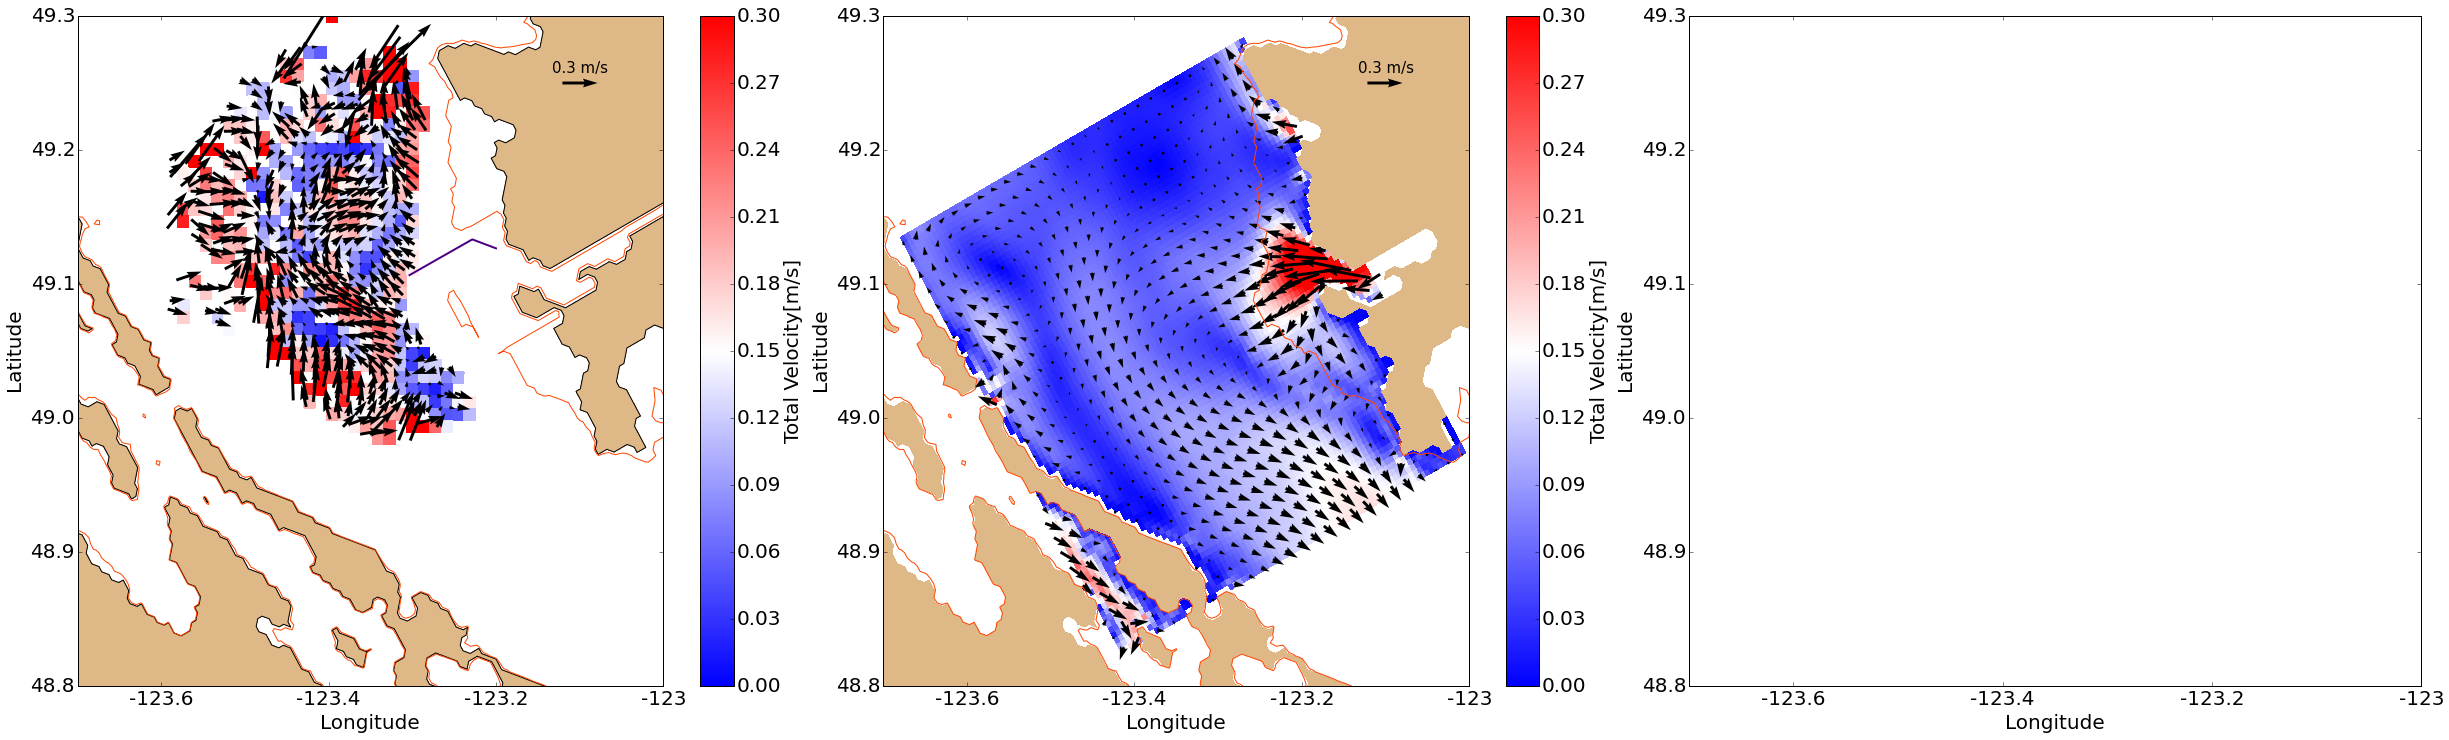

In [10]:
fig = plot_both(run_low,run_up)

# Test domain of CODAR.nc to run model with bathy6

In [11]:
a = nc.Dataset('CODAR.nc')
alon = a.variables['nav_lon']
alat = a.variables['nav_lat']
au = a.variables['vozocrtx']

In [12]:
j,i = tidetools.find_closest_model_point(alon[-1,-1],alat[-1,-1],X[grid6],Y[grid6],bathy[grid6])
print (j,i)

459 318


In [13]:
c = nc.Dataset('mean_U.nc')
cu = c.variables['vozocrtx']
clon = c.variables['nav_lon']
clat = c.variables['nav_lat']

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


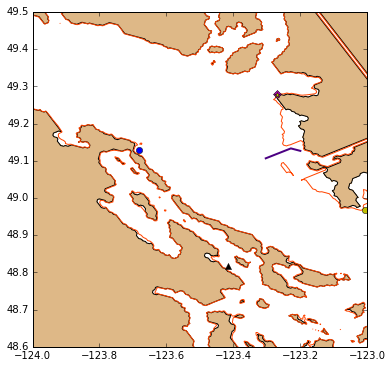

In [14]:
fig,ax = plt.subplots(1,1,figsize = (6,6))
##plot codar quiver
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'OrangeRed')
viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
ax.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
ax.set_xlim([-124,-123])
ax.set_ylim([48.6,49.5])
ax.plot(alon[-1,0],alat[-1,0],'ob') ## (459,240)
ax.plot(alon[0,0],alat[0,0],'^k') ## (380, 240)
ax.plot(alon[0,-1],alat[0,-1],'oy') ##(380,319)
ax.plot(clon[459,319],clat[459,319],'mD') ## (459, 318)
ax.plot(alon[-1,-1],alat[-1,-1],'y*') ##(459, 319)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


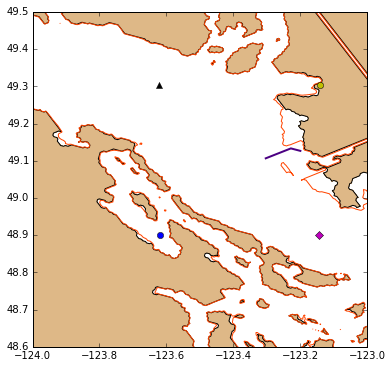

In [15]:
fig,ax = plt.subplots(1,1,figsize = (6,6))
##plot codar quiver
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'OrangeRed')
viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
ax.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
ax.set_xlim([-124,-123])
ax.set_ylim([48.6,49.5])
ax.plot(lon_codar[-1,0],lat_codar[-1,0],'ob')
ax.plot(lon_codar[0,0],lat_codar[0,0],'^k')
ax.plot(lon_codar[0,-1],lat_codar[0,-1],'oy')
ax.plot(lon_codar[-1,-1],lat_codar[-1,-1],'mD')